# Find the Maximum Common Substructure, and Groups Off It, Between a Set of Molecules Using RDKit

In drug discovery, the lead optimization step often involves creating analogues of a hit (a promising compound which produces a desired result in an assay) to optimize selectivity and minimize toxicity. Because it is typically easier to chemically modify the periphery of the molecule (for example the functional groups) than the scaffold, it is helpful to compare the groups off of the common scaffold. This utility function uses RDKit to find the maximum common substructure (MCS) between a set of molecules, then show the groups off of that MCS.

In a previous blog post ***link***, I found and highlighted the maximum common substructure (MCS) between a set of molecules by creating a function `SmilesMCStoGridImage` using RDKit. This post takes it a step further by identifying and showing the groups off the MCS. These might be R groups off a core scaffold.

*[Download this notebook from GitHub by right-clicking and choosing Save Link As...](***)*

The key RDKit commands it uses are:
- [ReplaceCore](***) to mask out the MCS in each molecule
- [GetMolFrags](***) to get the molecular fragments (groups) off of the MCS
- [`FindMCS`](https://www.rdkit.org/docs/source/rdkit.Chem.rdFMCS.html) to find the maximum common substructure (SMARTS string)
- [`MolFromSmarts`](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html) to generate a molecule corresponding to the maximum common substructure
- [`GenerateDepictionMatching2DStructure`](http://rdkit.org/docs/source/rdkit.Chem.rdDepictor.html) to align the matching substructure
- [`MolsToGridImage`](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html) to draw the grid of the MCS, the molecules with that MCS highlighted, and the groups off of the MCS for each molecule

To show the groups off of the MCS, the grid of molecular images is two-dimensional where:
- The first row is the MCS, and each subsequent row represents an input molecule
- Each row for a molecule (starting with the second row) also shows the groups off of the MCS

Here's an example, annotated to explain the grid arrangement:

*TODO Add annotated image*

In [2292]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS

In [2293]:
# Utilities
def flatten_twoD_list(twoD_list: list[list]) -> list:
    flat_list = []
    for row in twoD_list:
        for item in row:
            flat_list += [item]
    return flat_list

def longest_row(twoD_list: list[list]) -> int:
    return max(len(row) for row in twoD_list)

def pad_rows(twoD_list: list[list], row_length: int, filler = "") -> list[list]:
    for row in twoD_list:
        padding = row_length - len(row)
        row += [filler] * padding
    return twoD_list


In [2294]:
def SmilesMCStoGridImage(smiles: list[str] or dict[str, str], align_substructure: bool = True, groups: bool = False, verbose: bool = False, **kwargs):
     """
     Convert a list (or dictionary) of SMILES strings to an RDKit grid image of the maximum common substructure (MCS) match between them

     :returns: RDKit grid image, and (if verbose=True) MCS SMARTS string and molecule, and list of molecules for input SMILES strings
     :rtype: RDKit grid image, and (if verbose=True) string, molecule, and list of molecules
     :param smiles: The SMILES strings of the molecules to be compared and drawn
     :type smiles: List of (SMILES) strings, or dictionary of (SMARTS) string: (legend) string pairs
     :param align_substructure: Whether to align the MCS substructures when plotting the molecules; default is True
     :type align_substructure: boolean
     :param groups: Whether to show groups off the MCS in the grid of molecules; default is False
     :type groups: boolean
     :param verbose: Whether to return verbose output (MCS SMARTS string and molecule, and list of molecules for input SMILES strings); default is False so calling this function will present a grid image automatically
     :type verbose: boolean
     """

     mols = [Chem.MolFromSmiles(smile) for smile in smiles]
     res = rdFMCS.FindMCS(mols, **kwargs)
     mcs_smarts = res.smartsString
     mcs_mol = Chem.MolFromSmarts(mcs_smarts)

     mcs_legend = "Max. substructure match"

     # If user supplies a dictionary, use the values as legend entries for molecules
     if isinstance(smiles, dict):
          mol_smiles = [key for key in smiles.keys()]
          mol_legends = [smiles[molecule] for molecule in smiles]
     else:
          mol_smiles = smiles
          mol_legends = ["" for mol in mols]

     matches_mols = [mol.GetSubstructMatch(mcs_mol) for mol in mols]

     Chem.Compute2DCoords(mcs_mol)

     if groups:
          # TODO handle when there is no MCS--skip this block entirely? Provide a warning?

          # Prepare 2D lists
          smiles_2D = []
          legends_2D = []
          matches_2D = []

          for mol_index, mol in enumerate(mols):
               # Replace core and get groups
               res = Chem.ReplaceCore(mol, mcs_mol)
               groups = Chem.GetMolFrags(res, asMols = True)
               groups_smiles = [Chem.MolToSmiles(group) for group in groups]

               # Set up 2D matrix (nested list):
               #    Max. substructure match
               #    Molecule 1                Mol1Group1   Mol1Group2
               #    Molecule 2                Mol2Group1

               # Make smiles into 2D list with
               #   one molecule in each top-level list, then
               #   the groups off the MCS for that molecule
               smiles_2D += [[mol_smiles[mol_index], *groups_smiles]]

               # Make legends into 2D list; add SMILES for each group
               legends_2D += [[mol_legends[mol_index], *groups_smiles]]

               # Make matching atoms into 2D list
               matches_2D += [[matches_mols[mol_index]]]

          # Add MCS row and pad rows so MolsToGridImage will have one molecule (and its groups) per row
          longest_row = max(len(row) for row in smiles_2D)

          mcs_and_smiles_2D = [[mcs_smarts]] + smiles_2D
          mcs_and_smiles_2D = pad_rows(mcs_and_smiles_2D, longest_row)

          legends_2D = [[mcs_legend]] + legends_2D
          legends_2D = pad_rows(legends_2D, longest_row)

          matches_2D = [[]] + matches_2D
          matches_2D = pad_rows(matches_2D, longest_row, ())

          # Generate molecules from codes (SMARTS and SMILES) in 2D list
          mcs_and_mols_2D = []
          for row_index, row in enumerate(mcs_and_smiles_2D):
               row_adding = []
               for item_index, item in enumerate(row):
                    # MCS is a SMARTS string
                    if row_index == item_index == 0:
                         row_adding += [Chem.MolFromSmarts(item)]
                    # All other entries are SMILES strings
                    else:
                         row_adding += [Chem.MolFromSmiles(item)]
               mcs_and_mols_2D += [row_adding]

          # Align cores if requested
          if align_substructure:
               subms = []
               for row_index, row in enumerate(mcs_and_mols_2D[1:]):
                    subms += [row[0]]

               Chem.Compute2DCoords(mcs_mol)

               for m in subms:
                    _ = Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)

          # Add atom numbers to molecules that were input (not MCS or groups)
          #   Commenting out for now because isotope numbers in groups do no match atom numbers in molecule
          for row in mcs_and_mols_2D[1:]:
               for atom in row[0].GetAtoms():
                    # For each atom, set the property "atomNote" to a index+1 of the atom
                    # atom.SetProp("atomNote", str(atom.GetIdx()+1))
                    atom.SetProp("atomNote", str(atom.GetIdx()))

          # Convert 2D list back to 1D so MolsToGridImage can handle it
          mcs_and_mols = flatten_twoD_list(mcs_and_mols_2D)
          legends = flatten_twoD_list(legends_2D)
          matches = flatten_twoD_list(matches_2D)

          mcs_and_mols[0] = mcs_mol

          drawing = Draw.MolsToGridImage(mcs_and_mols, highlightAtomLists = matches, legends = legends, molsPerRow = longest_row)

     else:
          mcs_and_mols = [mcs_mol] + mols
          subms = [x for x in mcs_and_mols if x.HasSubstructMatch(mcs_mol)]
          legends = [mcs_legend] + mol_legends

          # Align cores if requested
          if align_substructure:
               for m in subms:
                    _ = Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)

          matches = [""] + matches_mols
          drawing = Draw.MolsToGridImage(mcs_and_mols, highlightAtomLists = matches, legends = legends, useSVG=True)

     if verbose:
          return drawing, mcs_smarts, mcs_mol, mols
     else:
          return drawing

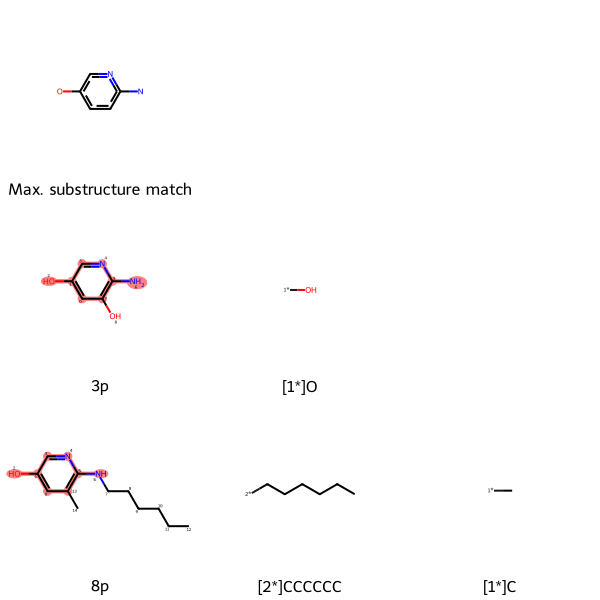

In [2344]:
# ms = {'c1c(O)cnc(N(C)(C))c1': '3', 'c1(C)c(O)c(C)nc(N(C)(C))c1': '4', 'c1(C)c(O)c(C)nc(N)c1(C)': '5', 'c1(C)c(O)c(C)nc(N(CCCCCC))c1(C)': '8'}
# ms = {'c1(C)c(O)c(C)nc(N)c1(C)': '5', 'c1(C)c(O)c(C)nc(N(CCCCCC))c1(C)': '8'}
# ms = {'c1(C)c(O)c(C)nc(N(C)(C))c1': '4', 'c1(C)c(O)c(C)nc(N(CCCCCC))c1(C)': '8'}
# ms = {'c1(C)c(O)c(C)nc(N(C)(C))c1': '4', 'c1(C)c(O)c(C)nc(N(CCCCCC))c1(C)': '8', 'c1(C)c(O)c(C)nc(N(CCCCCC)(CCCCCC))c1(C)': '9'}
# ms = {'c1c(O)cnc(N(C)(C))c1': '3', 'c1(C)c(O)c(C)nc(N(C)(C))c1': '4', 'c1(C)c(O)c(C)nc(N(CCCCCC)(CCCCCC))c1(C)': '9'}
# ms = {'c1(C)c(O)c(C)nc(N(C)(C))c1': '4', 'c1(C)c(O)c(C)nc(N(CCCCCC)(CCCCCC))c1(C)': '9'}
# ms = {'c1c(O)cnc(N(C)(C))c1': '3', 'c1(C)c(O)c(C)nc(N(CCCCCC))c1(C)': '8'}
# ms = {'c1c(O)cnc(N(C))c(O)1': '3p', 'c1c(O)cnc(N(CCCCCC))c1(C)': '8p'}
ms = {'c1c(O)cnc(N)c(O)1': '3p', 'c1c(O)cnc(N(CCCCCC))c1(C)': '8p'}

SmilesMCStoGridImage(ms, groups=True)


## Verbose=True checks

In [2296]:
drawing_groups_dict, mcs_smarts_groups_dict, mcs_mol_groups_dict, mols_groups_dict = SmilesMCStoGridImage({'C1CCC1': 'core','C1C(O)C(CC)C1': 'two groups','CC1CCC1': 'one group'}, groups=True, verbose=True)

In [2297]:
drawing_groups_list, mcs_smarts_groups_list, mcs_mol_groups_list, mols_groups_list = SmilesMCStoGridImage(['C1CCC1','C1C(O)C(CC)C1','CC1CCC1'], groups=True, verbose=True)

In [2298]:
drawing_nogroups_list, mcs_smarts_nogroups_list, mcs_mol_nogroups_list, mols_nogroups_list = SmilesMCStoGridImage(['C1CCC1','C1C(O)C(CC)C1','CC1CCC1'], verbose=True)

In [2299]:
drawing_nogroups_dict, mcs_smarts_nogroups_dict, mcs_mol_nogroups_dict, mols_nogroups_dict = SmilesMCStoGridImage({'C1CCC1': 'core','C1C(O)C(CC)C1': 'two groups','CC1CCC1': 'one group'}, verbose=True)

### Tests that verbose outputs equal

In [2300]:
mcs_smarts_groups_dict == mcs_smarts_groups_list == mcs_smarts_nogroups_list == mcs_smarts_nogroups_dict

True

In [2301]:
Chem.MolToSmarts(mcs_mol_groups_dict) == Chem.MolToSmarts(mcs_mol_groups_list) == Chem.MolToSmarts(mcs_mol_nogroups_dict) == Chem.MolToSmarts(mcs_mol_nogroups_dict)

True

In [2302]:
mols_nogroups_dict

In [2303]:
# Check that length of each smiles list is the same
range(len(mols_nogroups_dict)) == range(len(mols_groups_list)) == range(len(mols_nogroups_list)) == range(len(mols_nogroups_dict))

True

In [2304]:
# Check that smiles are the same for each case
for i in range(len(mols_nogroups_dict)):
    print(Chem.MolToSmiles(mols_nogroups_dict[i]) == Chem.MolToSmiles(mols_groups_list[i]) == Chem.MolToSmiles(mols_nogroups_list[i]) == Chem.MolToSmiles(mols_nogroups_dict[i]))

True
True
True


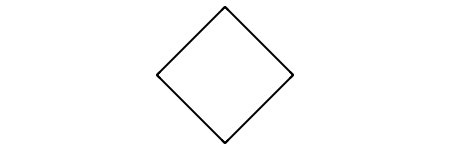

In [2305]:
mcs_mol_groups_list

## Verbose=False images

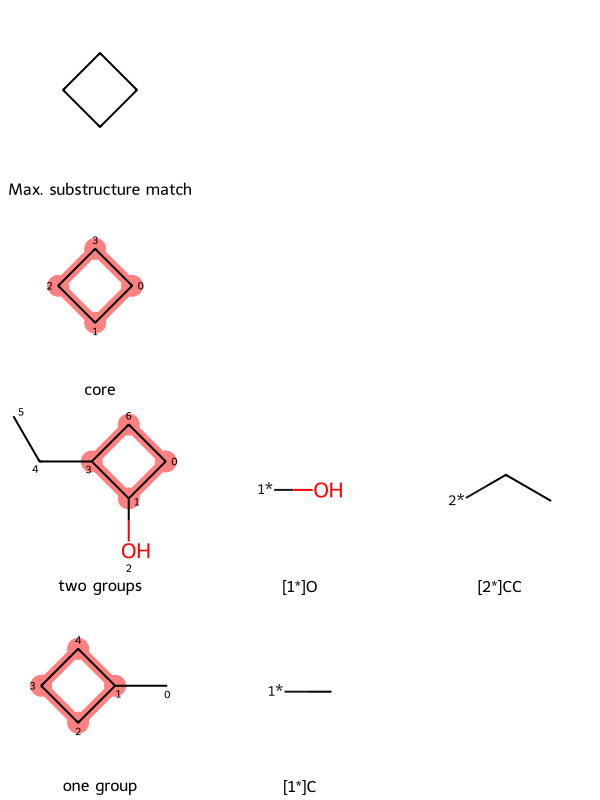

In [2306]:
SmilesMCStoGridImage({'C1CCC1': 'core','C1C(O)C(CC)C1': 'two groups','CC1CCC1': 'one group'}, groups=True)

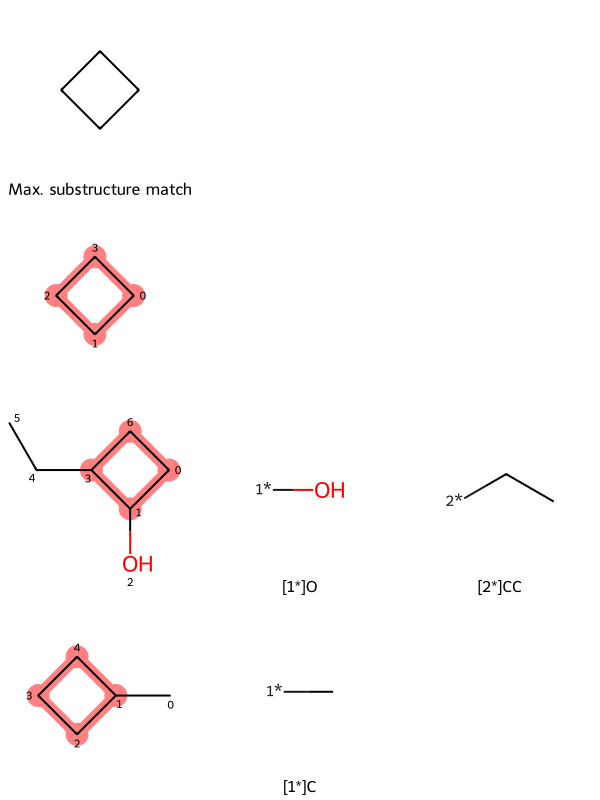

In [2307]:
SmilesMCStoGridImage(['C1CCC1','C1C(O)C(CC)C1','CC1CCC1'], groups=True)

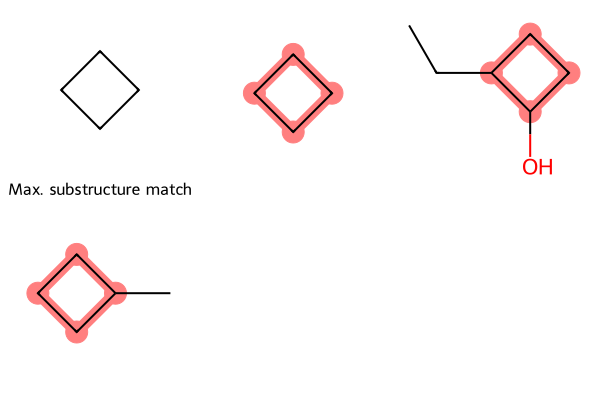

In [2308]:
SmilesMCStoGridImage(['C1CCC1','C1C(O)C(CC)C1','CC1CCC1'])

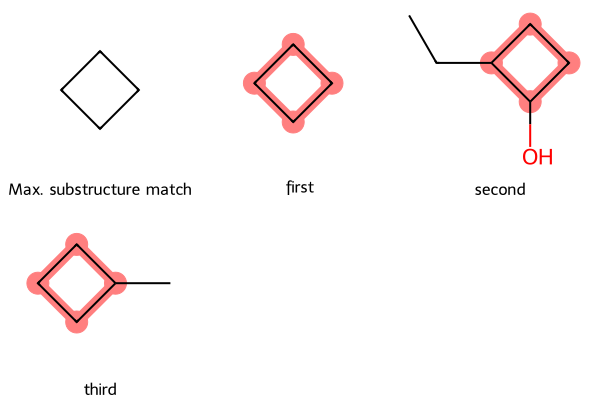

In [2309]:
SmilesMCStoGridImage({'C1CCC1': 'first','C1C(O)C(CC)C1': 'second','CC1CCC1': 'third'})

s='[1*]O.[2*]CC'
frags_as_mols=['[1*]O', '[2*]CC']
Chem.MolToSmiles(ms[1])='CCC1CCC1O'


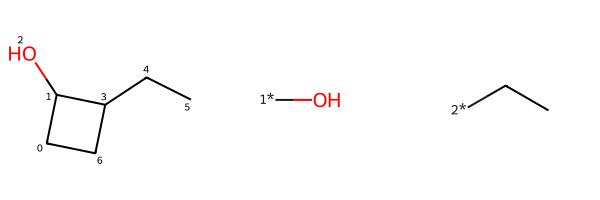

In [2310]:
ms = [Chem.MolFromSmiles(s) for s in ('C1CCC1','C1C(O)C(CC)C1','CC1CCC1')]

core = ms[0]

res = Chem.ReplaceCore(ms[1],core)

s = Chem.MolToSmiles(res)
# '[1*]O.[2*]CC'

print(f"{s=}")

frags = Chem.GetMolFrags(res,asMols=True)

frags_as_mols = [Chem.MolToSmiles(x) for x in frags]
print(f"{frags_as_mols=}")
# ['[1*]O', '[2*]CC']

print(f"{Chem.MolToSmiles(ms[1])=}")
for atom in ms[1].GetAtoms():
    # print(f"  Atom {atom.GetIdx()} is {atom.GetSymbol()}")
    # For each atom, set the property "atomNote" to index of the atom
    atom.SetProp("atomNote", str(atom.GetIdx()))
Draw.MolsToGridImage([ms[1], *frags])

In [2311]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdRGroupDecomposition

ms = [Chem.MolFromSmiles(s) for s in ('c1cnccc1','c(CCC)1c(O)nc(C)c(C)c(OO)1')]

core = ms[0]

res = Chem.ReplaceCore(ms[1],core)

s = Chem.MolToSmiles(res)

print(f"{s=}")

frags = Chem.GetMolFrags(res,asMols=True)

frags_as_mols = [Chem.MolToSmiles(x) for x in frags]
print(f"{frags_as_mols=}")

for atom in ms[1].GetAtoms():
    print(f"  Atom {atom.GetIdx()} is {atom.GetSymbol()}")
    # For each atom, set the property "atomNote" to index of the atom
    atom.SetProp("atomNote", str(atom.GetIdx()))
Draw.MolsToGridImage([ms[1], *frags], useSVG=True)

rgd,_ = rdRGroupDecomposition.RGroupDecompose([core],ms,asSmiles=True)
rgd


s='[1*]CCC.[2*]O.[3*]C.[4*]C.[5*]OO'
frags_as_mols=['[1*]CCC', '[2*]O', '[3*]C', '[4*]C', '[5*]OO']
  Atom 0 is C
  Atom 1 is C
  Atom 2 is C
  Atom 3 is C
  Atom 4 is C
  Atom 5 is O
  Atom 6 is N
  Atom 7 is C
  Atom 8 is C
  Atom 9 is C
  Atom 10 is C
  Atom 11 is C
  Atom 12 is O
  Atom 13 is O


[{'Core': 'n1c([*:3])c([*:2])c([*:1])c([*:5])c1[*:4]',
  'R1': '[H][*:1]',
  'R2': '[H][*:2]',
  'R3': '[H][*:3]',
  'R4': '[H][*:4]',
  'R5': '[H][*:5]'},
 {'Core': 'n1c([*:3])c([*:2])c([*:1])c([*:5])c1[*:4]',
  'R1': 'OO[*:1]',
  'R2': 'CCC[*:2]',
  'R3': 'O[*:3]',
  'R4': 'C[*:4]',
  'R5': 'C[*:5]'}]

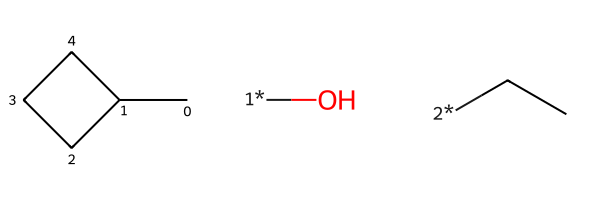

In [2312]:
# Using Chem.ReplaceCore
ms = [Chem.MolFromSmiles(s) for s in ('CC1CCC1', '[1*]O', '[2*]CC')]

for i, atom in enumerate(ms[0].GetAtoms()):
    atom.SetProp("atomNote", str(atom.GetIdx()))

Draw.MolsToGridImage(ms)

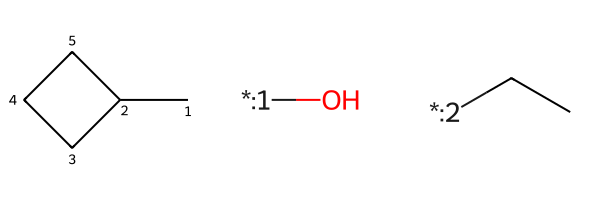

In [2313]:
# Using rdRGroupDecomposition
ms2 = [Chem.MolFromSmiles(s) for s in ('CC1CCC1', 'O[*:1]', 'CC[*:2]')]

for i, atom in enumerate(ms2[0].GetAtoms()):
    atom.SetProp("atomNote", str(atom.GetIdx()+1))

Draw.MolsToGridImage(ms2)

## Minimal Example

All you have to provide to `SmilesMCStoGridImage` is a list of SMILES strings, and it will return a grid image:

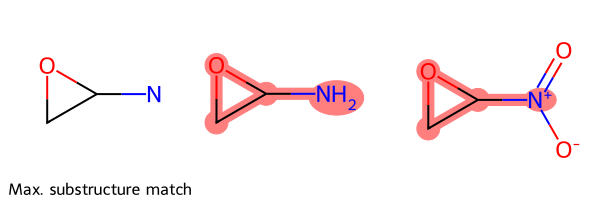

In [2314]:
SmilesMCStoGridImage(["NC1OC1", "C1OC1[N+](=O)[O-]"])

If there is no common substructure, the first cell in the grid will be empty (because there is no SMARTS match), and the molecules will be displayed without any highlighting:

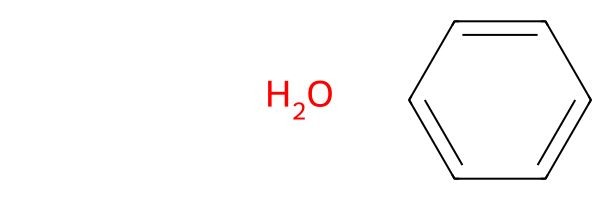

In [2315]:
SmilesMCStoGridImage(["O", "c1ccccc1"])

## Label Molecules

If you want to label the molecules in the grid image, provide a *dictionary* of molecules where each
- key is the SMILES string for that molecule
- value is the legend for that molecule, for example its name or a description

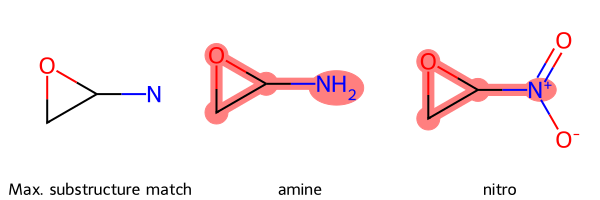

In [2316]:
SmilesMCStoGridImage({"NC1OC1": "amine", "C1OC1[N+](=O)[O-]": "nitro"})

## Get Additional Data

If you want `SmilesMCStoGridImage` to return not just the grid image, but also the substructure match and molecule, plus the molecules for the SMILES strings, set `verbose=True`:

In [2317]:
drawing, mcs, mcs_mol, mols = SmilesMCStoGridImage({"NC1OC1": "amine", "C1OC1[N+](=O)[O-]": "nitro"}, verbose=True)

You then must explicitly call the image to draw it:

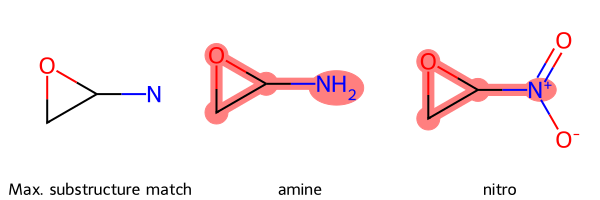

In [2318]:
drawing

`mcs` is the SMARTS string for the maximum common substructure (MCS):

In [2319]:
mcs

'[#7]-[#6]1-[#8]-[#6]-1'

`mcs_mol` is the molecular representation of that MCS:

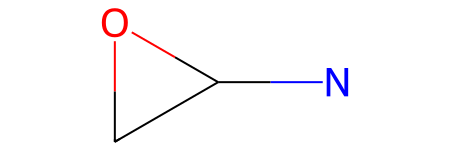

In [2320]:
mcs_mol

`mols` is the list of RDKit molecules:

In [2321]:
mols

You can plot each molecule, with the MCS highlighted, by indexing the molecule in `mols`:

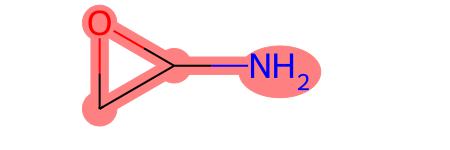

In [2322]:
mols[0]

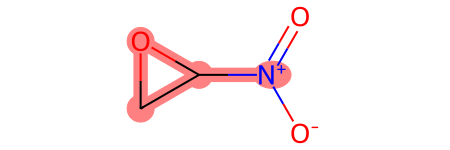

In [2323]:
mols[1]

## Caveat About Aligning Maximum Common Substructure
The SMARTS substructure match may not match the form of the molecule. For example, if you input two structures containing six-membered carbon rings, the SMARTS substructure match includes a linear chain of six carbons. So if you align the molecules to that substructure, you get some odd-looking "rings":

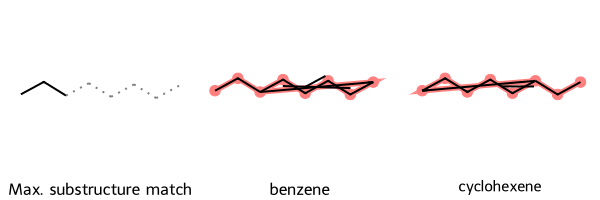

In [2324]:
SmilesMCStoGridImage({"CCc1ccccc1": "benzene", "C1CCCC=C1CC": "cyclohexene"})

To address this case, in `SmilesMCStoGridImage` you can set `align_substructure=False` (its default value is `True`), with the disadvantage that the molecules may not be aligned:

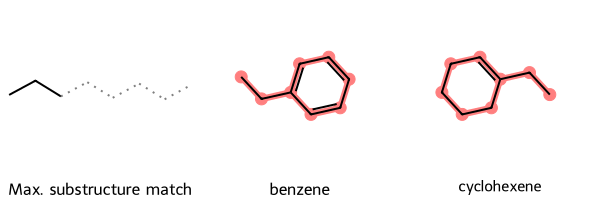

In [2325]:
SmilesMCStoGridImage({"CCc1ccccc1": "benzene", "C1CCCC=C1CC": "cyclohexene"}, align_substructure=False)

## Pass Arguments to FindMCS
`SmilesMCStoGridImage` will pass any keyword arguments of [`rdFMCS.FindMCS`](https://www.rdkit.org/docs/source/rdkit.Chem.rdFMCS.html) to that function. For example, by default, `rdFMCS.FindMCS` will match a pattern of atoms even if they are in a complete ring in one molecule, and not in another:

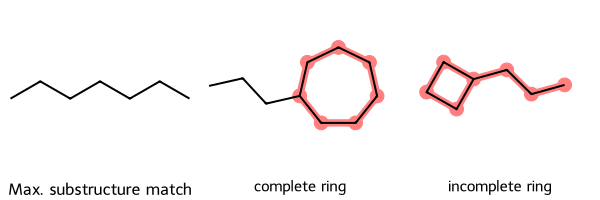

In [2326]:
SmilesMCStoGridImage({"C1CCCCCC1CCC": "complete ring", "C1CCC1CCC": "incomplete ring"}, align_substructure=False)

`rdFMCS.FindMCS` lets you set the flag `completeRingsOnly=True` to avoid matching these two molecules. You can call `SmilesMCStoGridImage` with `completeRingsOnly=True` to pass that flag to `rdFMCS.FindMCS` so that the two molecules won't produce a match:

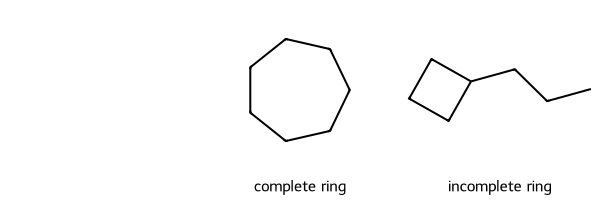

In [2327]:
SmilesMCStoGridImage({"C1CCCCCC1": "complete ring", "C1CCC1CCC": "incomplete ring"}, align_substructure=False, completeRingsOnly=True)

## Example With Larger Molecules

As a final example, here's a case with larger molecules:

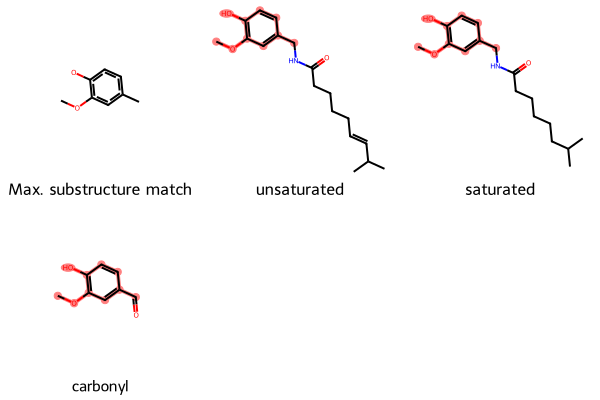

In [2328]:
SmilesMCStoGridImage({"O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C": "unsaturated", "CC(C)CCCCCC(=O)NCC1=CC(=C(C=C1)O)OC": "saturated", "c1(C=O)cc(OC)c(O)cc1": "carbonyl"})